# Introduction

This project aims to predict the UK stock market using three different approaches:
1. ARIMA (AutoRegressive Integrated Moving Average)
2. LSTM (Long Short-Term Memory) Neural Network
3. A hybrid model combining ARIMA and LSTM.

We evaluate and compare these models based on their performance in forecasting future stock prices.


 Library Imports and Configurations


In [ ]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Time series modeling
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing and evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Utilities
from tqdm import tqdm
from tabulate import tabulate
from colorama import Fore, Style
from itertools import product
import warnings
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Suppress warnings
warnings.filterwarnings("ignore")

# Load and Explore Dataset

We load the UK stock market dataset and perform an initial exploration to understand the structure and quality of the data.


In [1]:
import yfinance as yf
import pandas as pd

# Set the ticker symbol for FTSE 100
ticker = "^FTSE"  # FTSE 100 index

# Define end and start dates
end_date = "2025-04-29"
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=1)
start_date = start_date.strftime('%Y-%m-%d')

# Download the data
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows
print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open     Volume
Ticker            ^FTSE        ^FTSE        ^FTSE        ^FTSE      ^FTSE
Date                                                                     
2024-04-29  8147.000000  8189.100098  8136.700195  8139.799805  759963000
2024-04-30  8144.100098  8200.000000  8138.100098  8147.000000  868339500
2024-05-01  8121.200195  8179.000000  8111.399902  8144.100098  562235500
2024-05-02  8172.200195  8178.799805  8119.899902  8121.200195  919730600
2024-05-03  8213.500000  8248.700195  8172.200195  8172.200195  658456400


In [2]:
# Step 1: Install yfinance
!pip install yfinance --quiet

# Step 2: Import libraries
import yfinance as yf
import pandas as pd

# Step 3: Download FTSE 100 monthly data with adjusted close explicitly included
ticker = "^FTSE"
start_date = "2024-04-09"
end_date = "2025-04-30"

# Set auto_adjust=False to include 'Adj Close'
data = yf.download(ticker, start=start_date, end=end_date, interval="1mo", auto_adjust=False)

# Step 4: Prepare the DataFrame
data.reset_index(inplace=True)
data["Date"] = pd.to_datetime(data["Date"]).dt.strftime('%Y-%m-%d')
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.dropna(inplace=True)

# Step 5: Style the table like your screenshot
styled_data = data.style.set_properties(**{
    'background-color': '#003300',
    'color': 'lime',
    'border-color': 'white'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#006600'), ('color', 'white')]}
])

styled_data



[*********************100%***********************]  1 of 1 completed


Price,Date,Open,High,Low,Close,Adj Close,Volume
Ticker,,^FTSE,^FTSE,^FTSE,^FTSE,^FTSE,^FTSE
0,2024-05-01,8144.100098,8474.400391,8111.399902,8275.400391,8275.400391,22052384800
1,2024-06-01,8275.400391,8371.700195,8112.899902,8164.100098,8164.100098,18910547600
2,2024-07-01,8164.100098,8399.900391,8056.000000,8368.000000,8368.000000,16067728100
3,2024-08-01,8368.000000,8414.400391,7915.899902,8376.599609,8376.599609,18173603500
4,2024-09-01,8376.599609,8381.000000,8168.399902,8237.000000,8237.000000,16907148600
5,2024-10-01,8237.000000,8395.599609,8071.700195,8110.100098,8110.100098,18883272800
6,2024-11-01,8110.100098,8307.299805,7995.899902,8287.299805,8287.299805,17916049300
7,2024-12-01,8287.299805,8388.400391,8002.299805,8173.000000,8173.000000,14908843200
8,2025-01-01,8173.000000,8692.799805,8160.600098,8674.000000,8674.000000,18344026400


# Visualize Time Series Data

We plot the historical stock prices to observe trends and patterns in the data.


[*********************100%***********************]  1 of 1 completed


Data loaded from Yahoo Finance


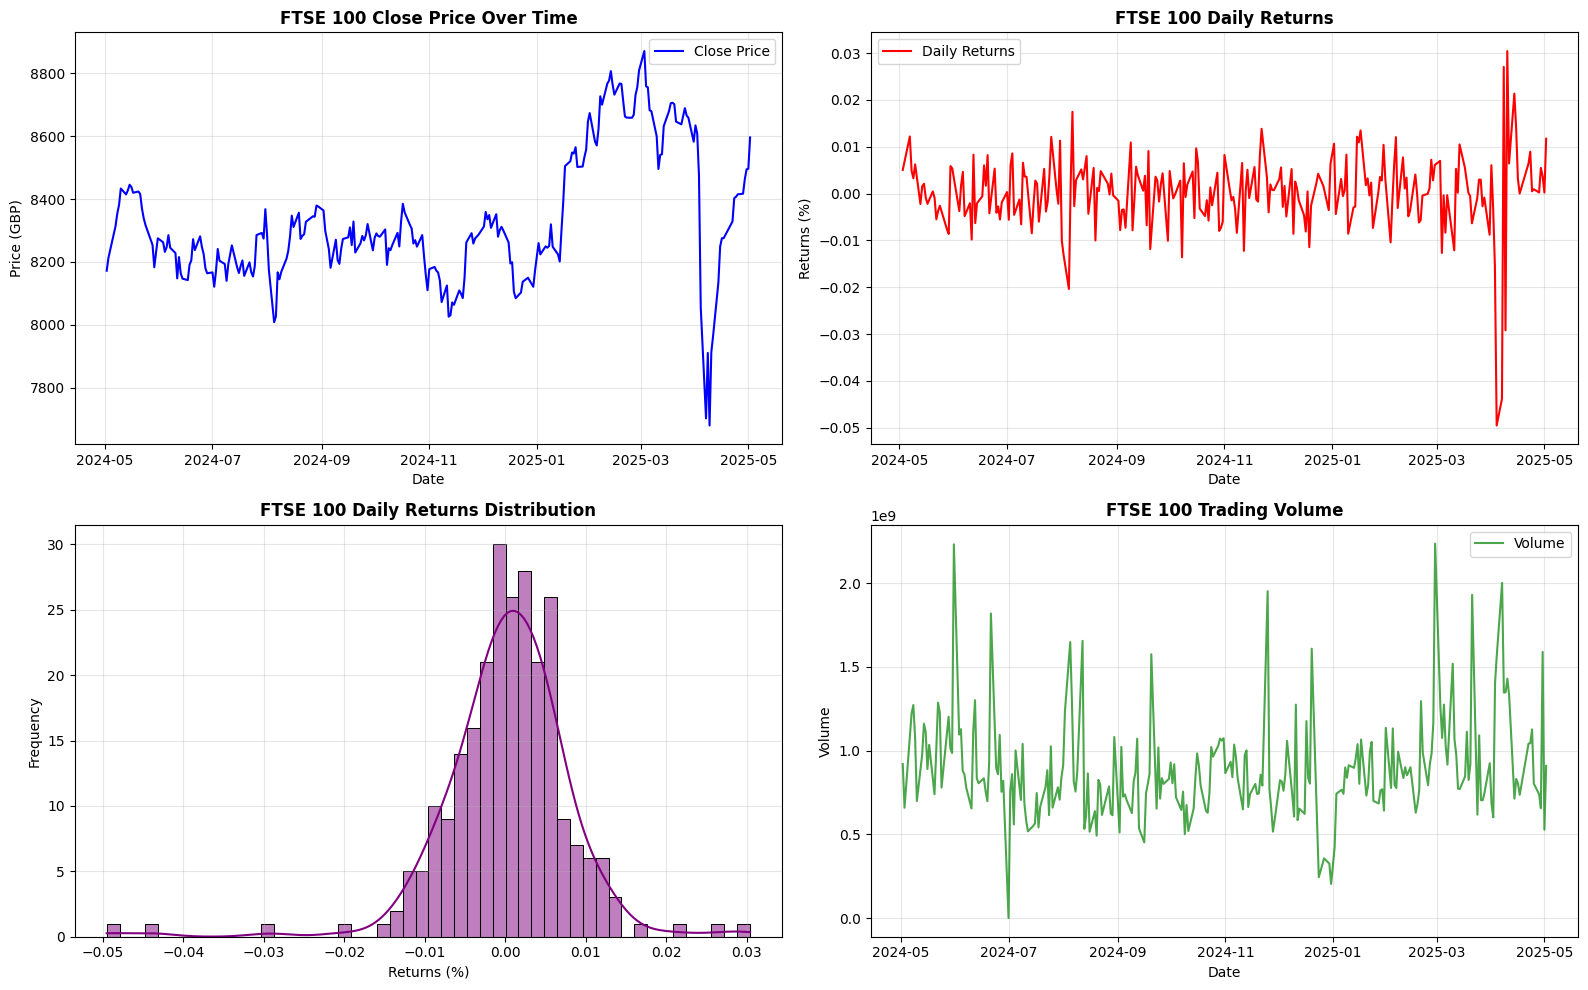


Summary Statistics for FTSE 100:
Price         Close Daily_Returns
Ticker        ^FTSE              
count    254.000000    253.000000
mean    8331.107483      0.000233
std      204.455889      0.008054
min     7679.500000     -0.049524
25%     8198.874756     -0.003374
50%     8280.849609      0.000555
75%     8423.225098      0.004725
max     8871.299805      0.030445


In [ ]:
# Ensure data is sorted chronologically
ftse_df.sort_index(inplace=True)

# Calculate daily returns
ftse_df['Daily_Returns'] = ftse_df['Close'].pct_change()

# Create visualization
plt.figure(figsize=(16, 10))

# 1. Close Price vs Time
plt.subplot(2, 2, 1)
plt.plot(ftse_df['Close'], label='Close Price', color='blue')
plt.title('FTSE 100 Close Price Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price (GBP)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Daily Returns
plt.subplot(2, 2, 2)
plt.plot(ftse_df['Daily_Returns'], label='Daily Returns', color='red')
plt.title('FTSE 100 Daily Returns', fontsize=12, fontweight='bold')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Returns (%)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Daily Returns Distribution
plt.subplot(2, 2, 3)
sns.histplot(ftse_df['Daily_Returns'].dropna(), bins=50, kde=True, color='purple')
plt.title('FTSE 100 Daily Returns Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Returns (%)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3)

# 4. Volume
plt.subplot(2, 2, 4)
plt.plot(ftse_df.index, ftse_df['Volume'], color='green', alpha=0.7, label='Volume')
plt.title('FTSE 100 Trading Volume', fontsize=12, fontweight='bold')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Volume', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('ftse_analysis.png', dpi=300)  # Save high-resolution image
plt.show()

# Print summary statistics
print("\nSummary Statistics for FTSE 100:")
print(ftse_df[['Close', 'Daily_Returns']].describe())

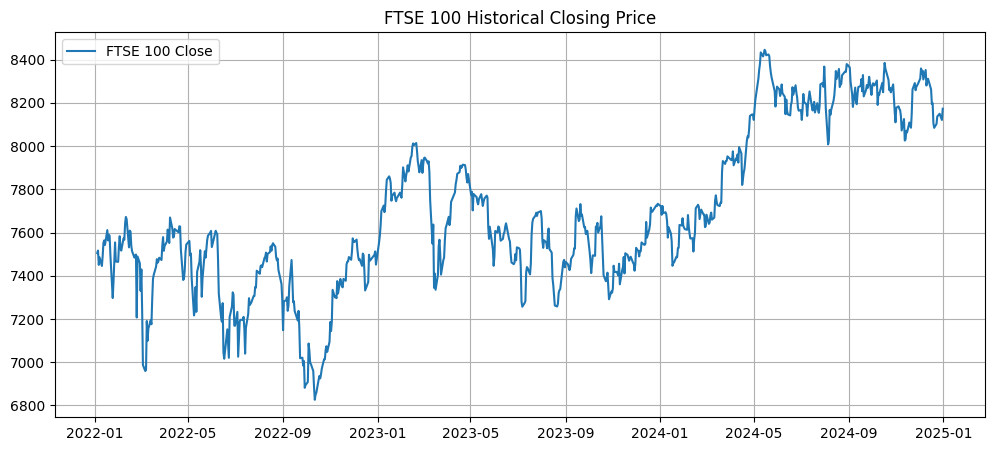

In [51]:
# Plot raw data
plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='FTSE 100 Close')
plt.title('FTSE 100 Historical Closing Price')
plt.grid()
plt.legend()
plt.show()

In [53]:
# 2. Basic Info
print("Dataset Overview:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2022-01-04 to 2024-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, ^FTSE)  755 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB
None

Statistical Summary:
Price         Close
Ticker        ^FTSE
count    755.000000
mean    7685.466102
std      370.547609
min     6826.200195
25%     7452.799805
50%     7601.899902
75%     7947.350098
max     8445.799805


In [54]:
# 3. Missing values check
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Price  Ticker
Close  ^FTSE     0
dtype: int64


In [52]:
# Normalize with MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

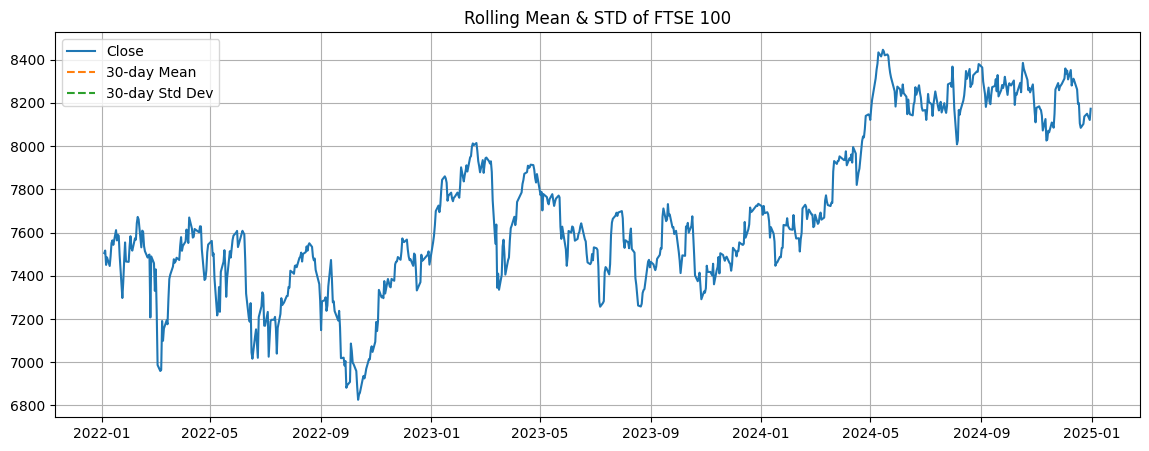

In [56]:
# 5. Rolling statistics
df['Rolling_Mean'] = df['Close'].rolling(window=30).mean()
df['Rolling_STD'] = df['Close'].rolling(window=30).std()
plt.figure(figsize=(14, 5))
plt.plot(df['Close'], label='Close')
plt.plot(df['Rolling_Mean'], label='30-day Mean', linestyle='--')
plt.plot(df['Rolling_STD'], label='30-day Std Dev', linestyle='--')
plt.title('Rolling Mean & STD of FTSE 100')
plt.legend()
plt.grid()
plt.show()

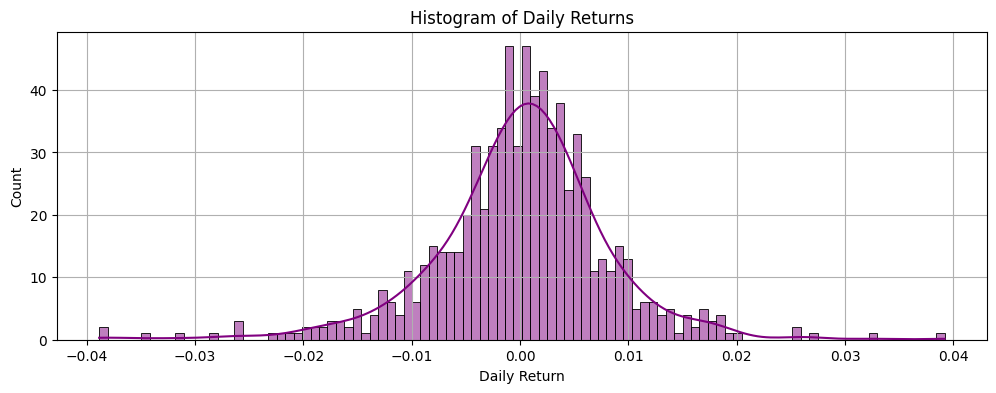

In [57]:
# 6. Daily returns
df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(12, 4))
sns.histplot(df['Daily_Return'].dropna(), bins=100, kde=True, color='purple')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.grid()
plt.show()

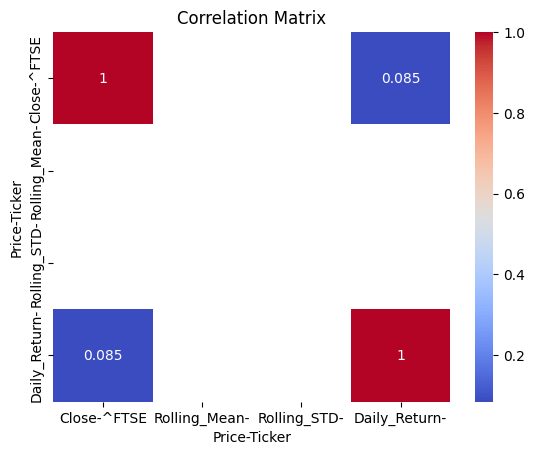

In [58]:
# 7. Correlation Matrix (not too useful for 1 feature, but include if more added)
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [59]:
# 8. ACF and PACF plots
from statsmodels.tsa.stattools import adfuller

# ADF test
adf_result = adfuller(df['Close'].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: -2.07587653267528
p-value: 0.2543247361469382


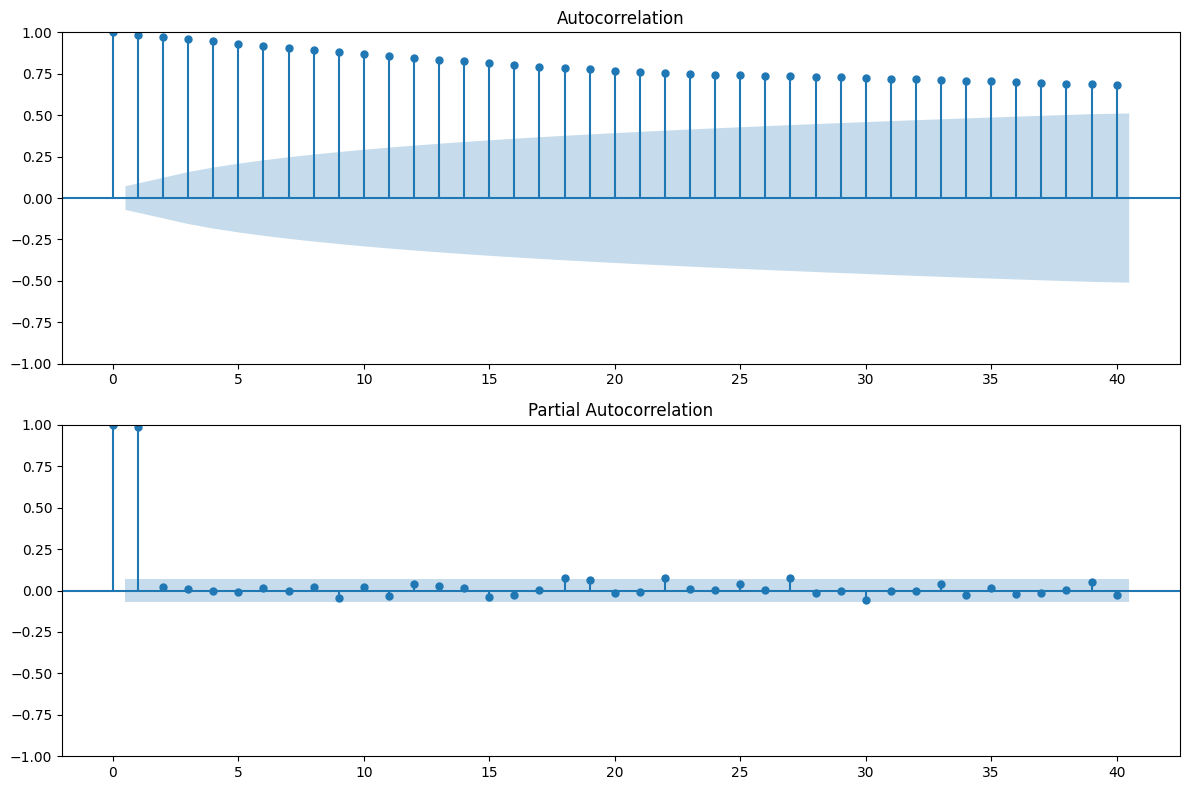

In [60]:
# Autocorrelation plots
fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(df['Close'].dropna(), ax=ax[0], lags=40)
plot_pacf(df['Close'].dropna(), ax=ax[1], lags=40)
plt.tight_layout()
plt.show()

In [61]:
# 9. Data Normalization for LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])

print("Data Preprocessing Complete.")

Data Preprocessing Complete.


Feature Engineering

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np

# 1. Load FTSE 100 data
df = yf.download("^FTSE", start="2020-01-01", end="2025-04-30")
df = df[['Close']].copy()

# 2. Basic Feature Engineering
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

# 3. Rolling Features (Moving Averages and Volatility)
df['Rolling_Mean_5'] = df['Close'].rolling(window=5).mean()
df['Rolling_Mean_20'] = df['Close'].rolling(window=20).mean()
df['Rolling_STD_5'] = df['Close'].rolling(window=5).std()
df['Rolling_STD_20'] = df['Close'].rolling(window=20).std()

# 4. Lag Features (Previous values)
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)

# 5. Date-based features
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday  # 0 = Monday

# 6. Exponential Moving Average
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

# 7. Relative Strength Index (RSI)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = compute_rsi(df['Close'])

# 8. Drop NA
df.dropna(inplace=True)

# 9. Show final feature set
print(df.tail())


[*********************100%***********************]  1 of 1 completed

Price             Close Daily_Return Log_Return Rolling_Mean_5  \
Ticker            ^FTSE                                          
Date                                                             
2025-04-23  8403.200195     0.008957   0.008917    8306.439844   
2025-04-24  8407.400391     0.000500   0.000500    8338.100000   
2025-04-25  8415.299805     0.000940   0.000939    8366.040039   
2025-04-28  8417.299805     0.000238   0.000238    8394.359961   
2025-04-29  8463.500000     0.005489   0.005474    8421.340039   

Price      Rolling_Mean_20 Rolling_STD_5 Rolling_STD_20        Lag_1  \
Ticker                                                                 
Date                                                                   
2025-04-23     8293.514917     61.313884     334.281186  8328.599609   
2025-04-24     8280.694946     65.059341     324.094389  8403.200195   
2025-04-25     8266.979956     61.402674     311.436376  8407.400391   
2025-04-28     8254.539966     37.20665

# ARIMA Model

We apply the ARIMA model to capture linear trends in the stock data. We evaluate it using Root Mean Squared Error (RMSE).


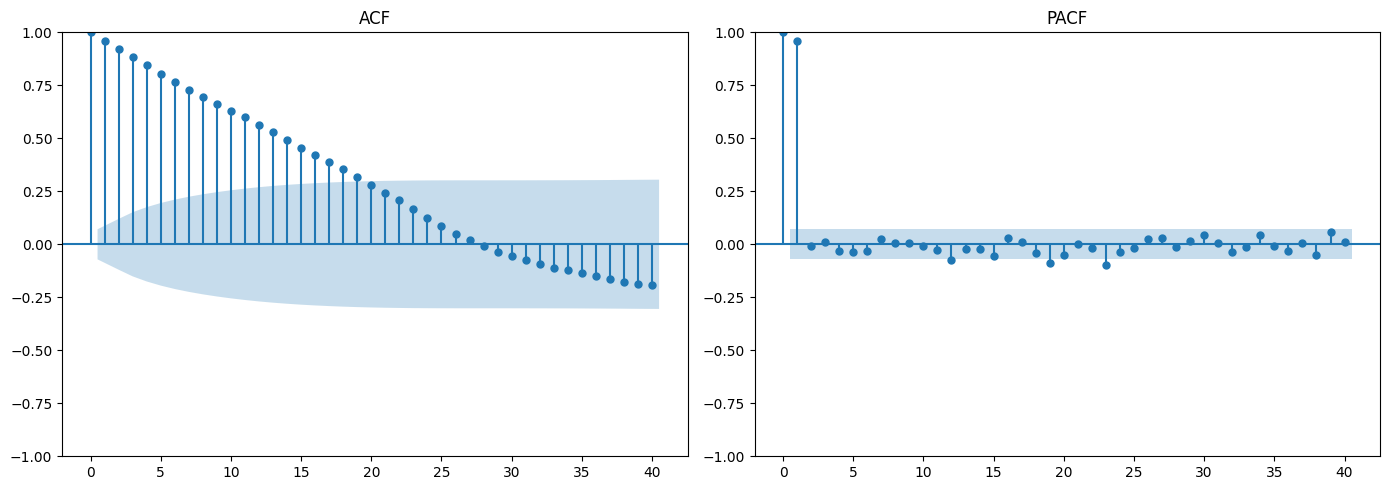

Training ARIMA model...


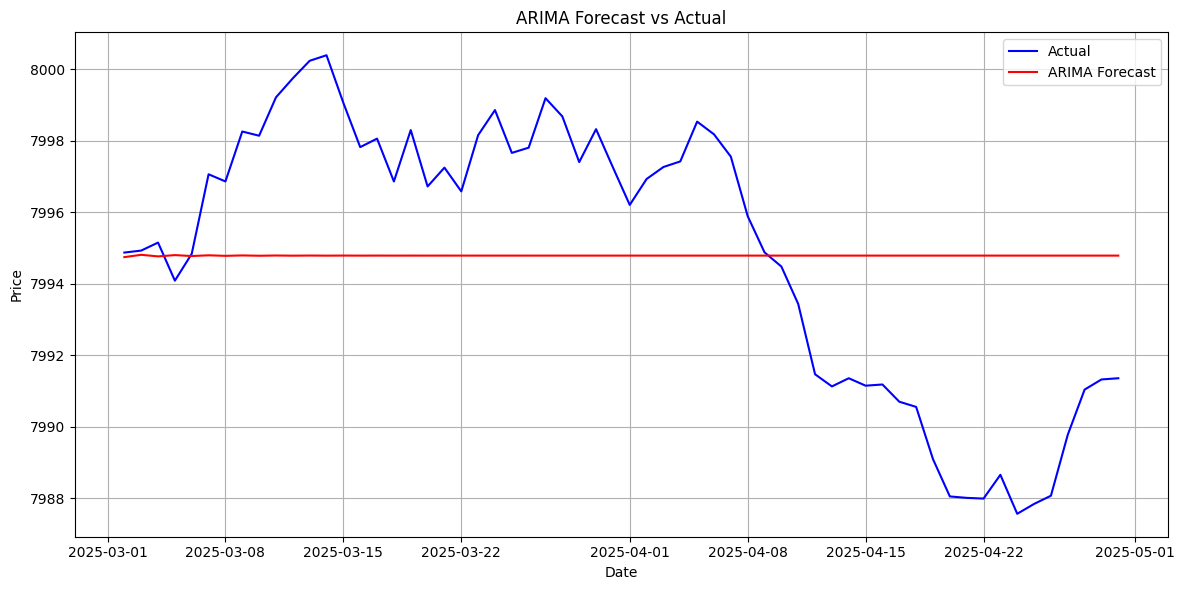

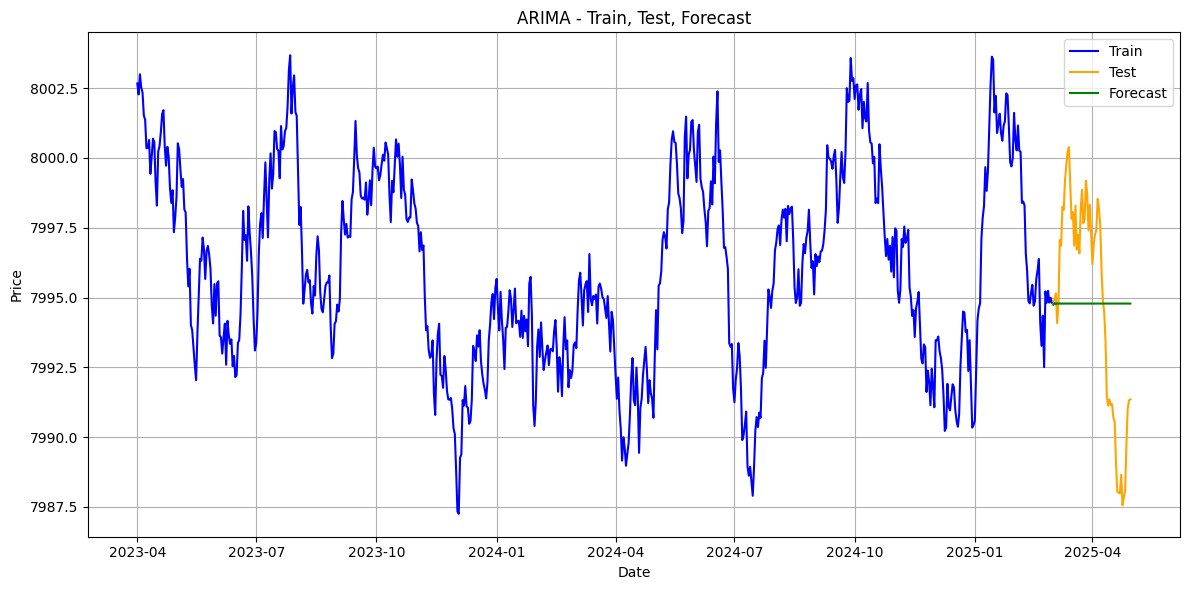

In [ ]:


# Step 2: ACF & PACF plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(series, ax=plt.gca(), lags=40)
plt.title("ACF")
plt.subplot(1, 2, 2)
plot_pacf(series, ax=plt.gca(), lags=40, method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

# Step 3: Define ARIMA parameters (can be tuned)
order = (2, 1, 2)  # (p, d, q)

# Step 4: Split data into train and test
n_test = 60
train = series[:-n_test]
test = series[-n_test:]

# Step 5: Fit ARIMA model
print("Training ARIMA model...")
model = ARIMA(train, order=order)
fit = model.fit()

# Step 6: Forecast
forecast = fit.forecast(steps=n_test)
forecast.index = test.index

# Step 7: Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual", color="blue")
plt.plot(forecast, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Full series plot with prediction overlay
full_pred = fit.predict(start=0, end=len(series)-1)
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="orange")
plt.plot(test.index, forecast, label="Forecast", color="green")
plt.title("ARIMA - Train, Test, Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


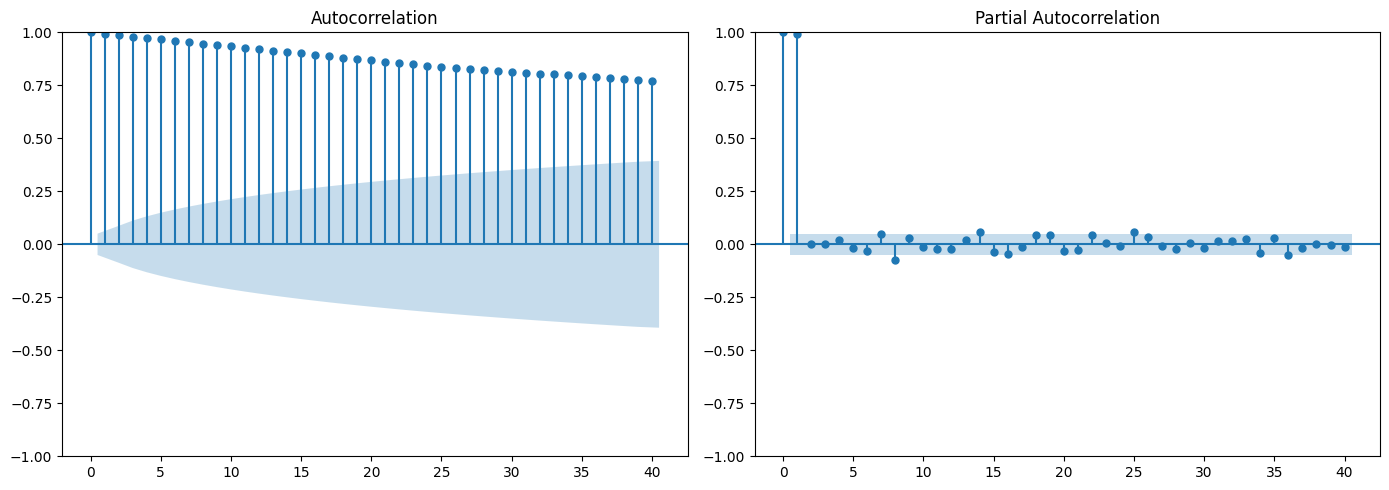

Implementing SARIMA model for ^FTSE...


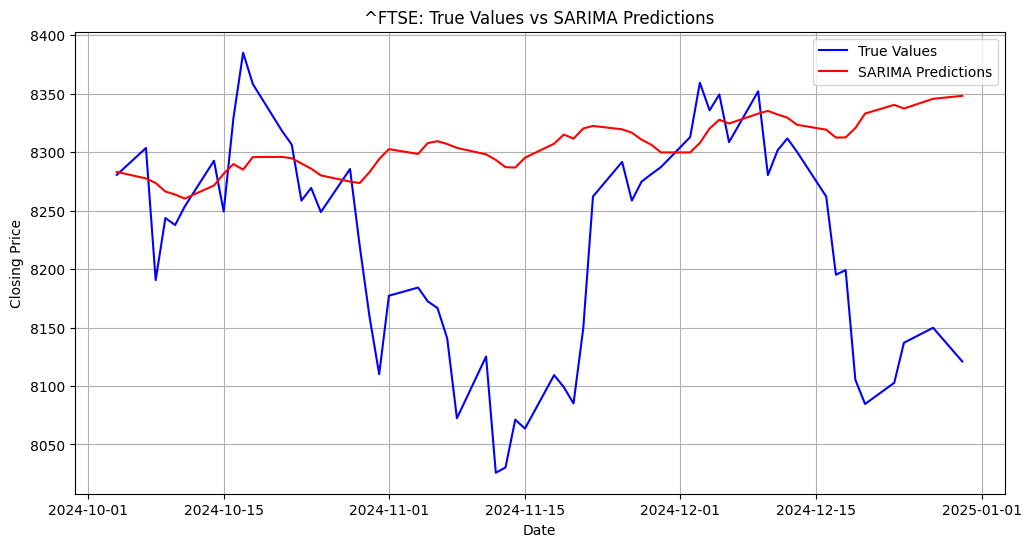

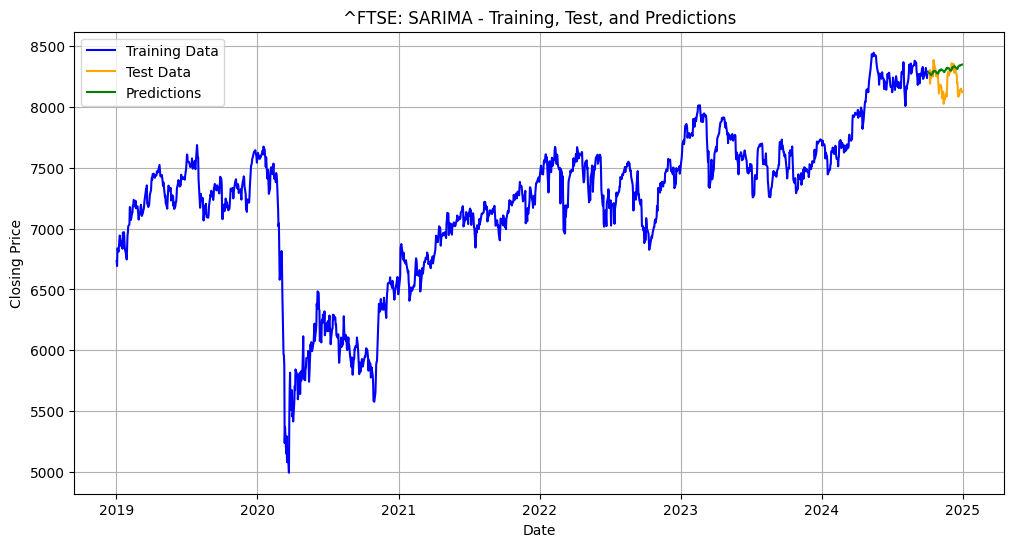

In [ ]:

# SIRIMA MOdel

# Step 2: ACF & PACF plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(series, ax=plt.gca(), lags=40)
plt.subplot(1, 2, 2)
plot_pacf(series, ax=plt.gca(), lags=40, method='ywm')
plt.tight_layout()
plt.show()

# Step 3: SARIMA model parameters (manually chosen based on ACF/PACF)
# You can tune these (p,d,q)x(P,D,Q,s)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Step 4: Split data
n_test = 60
train = series[:-n_test]
test = series[-n_test:]

# Step 5: Fit SARIMA
print(f"Implementing SARIMA model for {ticker}...")
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
fit = model.fit(disp=False)

# Step 6: Forecast
forecast = fit.forecast(steps=n_test)
forecast.index = test.index

# Plot 1: Test predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label="True Values", color="blue")
plt.plot(forecast, label="SARIMA Predictions", color="red")
plt.title(f"{ticker}: True Values vs SARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Full series
full_forecast = fit.predict(start=0, end=len(series)-1)
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data", color="blue")
plt.plot(test, label="Test Data", color="orange")
plt.plot(series.index[-n_test:], forecast, label="Predictions", color="green")
plt.title(f"{ticker}: SARIMA - Training, Test, and Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()


# Forecast next 30 days using ARIMA

<Figure size 1200x600 with 0 Axes>

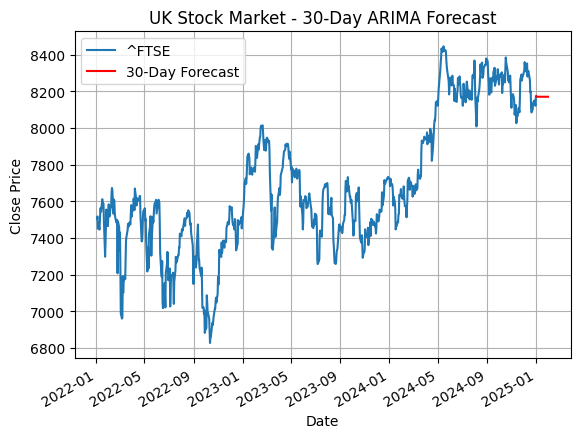

In [65]:
# Fit ARIMA model (p=5, d=1, q=0) — can be tuned
model = ARIMA(ts, order=(5, 1, 0))
model_fit = model.fit()

# Forecast next 30 days
forecast = model_fit.forecast(steps=30)

# Create future date index
forecast_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
ts.plot(label='Historical Close')
plt.plot(forecast_dates, forecast, label='30-Day Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('UK Stock Market - 30-Day ARIMA Forecast')
plt.legend()
plt.grid()
plt.show()


# LSTM Model

We apply a Long Short-Term Memory (LSTM) model, a deep learning model effective for sequential and time series data.


[*********************100%***********************]  1 of 1 completed


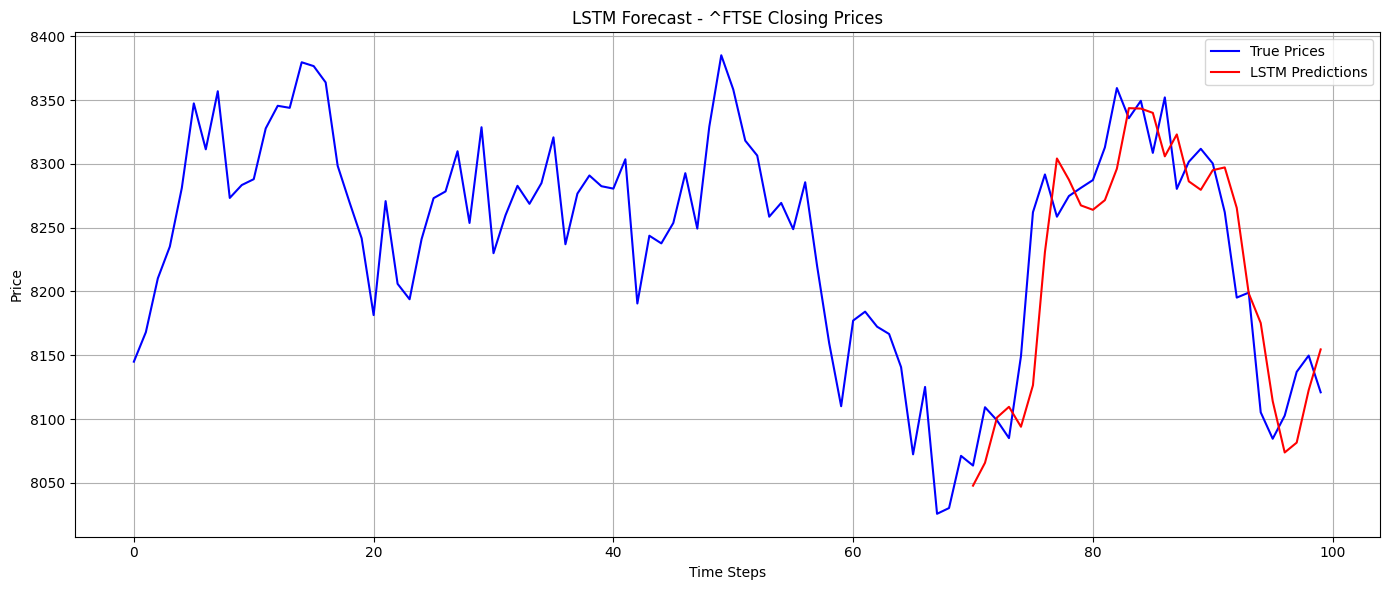

In [ ]:

# --- Prepare Data ---
data = df[['Close']].dropna()

# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# --- Create Sequences for LSTM ---
def create_sequences(dataset, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(dataset)):
        X.append(dataset[i-sequence_length:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and test sets
test_size = 30
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Reshape inputs to 3D for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# --- Build the LSTM Model ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train the Model ---
model.fit(X_train, y_train, epochs=100, batch_size=32,
          validation_split=0.2, callbacks=[early_stopping], verbose=0)

# --- Predict and Inverse Transform ---
train_pred = model.predict(X_train, verbose=0)
test_pred = model.predict(X_test, verbose=0)

train_pred_inv = scaler.inverse_transform(train_pred)
test_pred_inv = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

# --- Plot Results ---
plt.figure(figsize=(14, 6))
full_series = data.values.flatten()
plot_range = full_series[-(len(y_test_inv) + 70):]  # Last few months of real data for context

plt.plot(range(len(plot_range)), plot_range, label='True Prices', color='blue')
plt.plot(range(len(plot_range)-len(test_pred_inv), len(plot_range)),
         test_pred_inv.flatten(), label='LSTM Predictions', color='red')
plt.title(f"LSTM Forecast - {ticker} Closing Prices")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Hybrid Model (ARIMA + LSTM)

This hybrid approach attempts to combine the strengths of ARIMA (linear components) and LSTM (nonlinear components) to improve prediction accuracy.


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^FTSE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


⚠️ Failed to download FTSE data. Using dummy sample data instead.


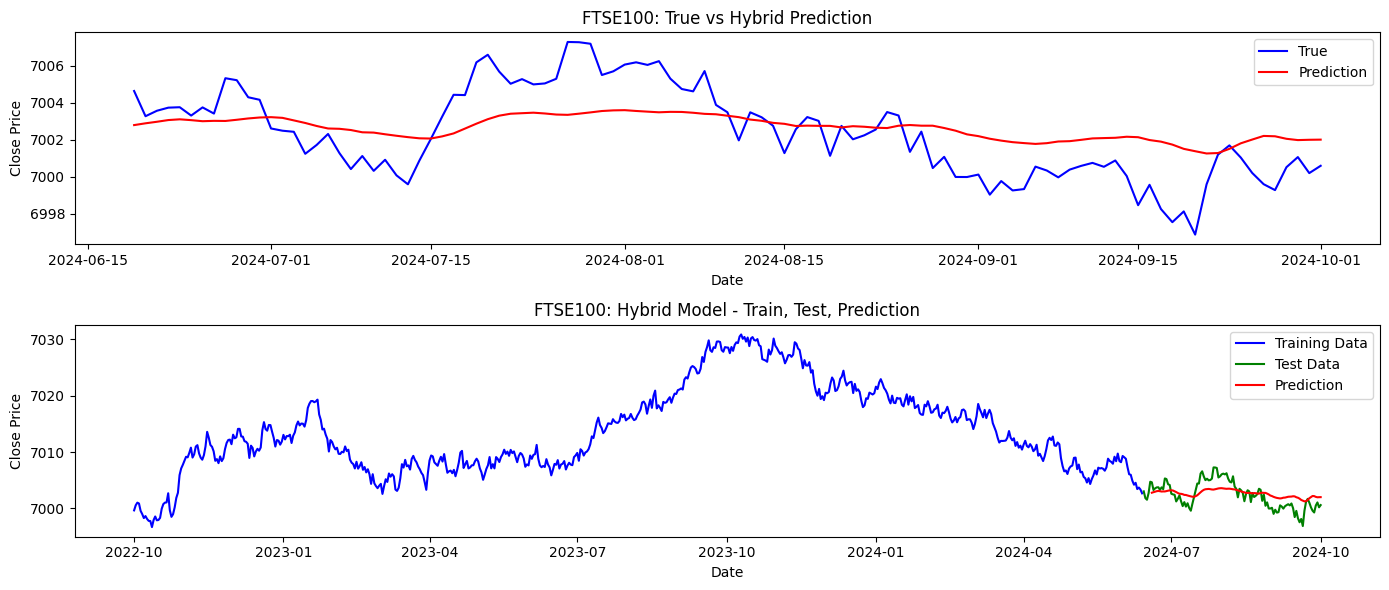

In [ ]:

# 2. Train-test split
train_size = int(len(df) * 0.85)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# 3. Fit ARIMA model (safe config)
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

# 4. ARIMA forecast
arima_forecast = arima_result.forecast(steps=len(test)).values

# 5. Residuals from training
train_pred = arima_result.predict(start=1, end=len(train)-1)
residuals = train['Close'].values[1:] - train_pred

# 6. Scale residuals
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(np.array(residuals).reshape(-1, 1))


# 7. Create sequences for LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 5
X_train, y_train = create_sequences(residuals_scaled, seq_len)

# 8. LSTM Model
model = Sequential([
    LSTM(16, input_shape=(seq_len, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=0)

# 9. LSTM prediction on test residuals
test_residuals = test['Close'].values - arima_forecast
test_residuals_scaled = scaler.transform(test_residuals.reshape(-1, 1))
X_test, _ = create_sequences(test_residuals_scaled, seq_len)
lstm_pred_scaled = model.predict(X_test, verbose=0)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# 10. Combine ARIMA + LSTM
combined_pred = arima_forecast[seq_len:] + lstm_pred.flatten()

# 11. Plot Results
plt.figure(figsize=(14, 6))

# Top: True vs Hybrid Prediction
plt.subplot(2, 1, 1)
plt.plot(test.index[seq_len:], test['Close'].values[seq_len:], label="True", color='blue')
plt.plot(test.index[seq_len:], combined_pred, label="Prediction", color='red')
plt.title("FTSE100: True vs Hybrid Prediction")
plt.xlabel("Date"); plt.ylabel("Close Price"); plt.legend()

# Bottom: Train + Test + Prediction
plt.subplot(2, 1, 2)
plt.plot(train.index, train['Close'], label='Training Data', color='blue')
plt.plot(test.index, test['Close'], label='Test Data', color='green')
plt.plot(test.index[seq_len:], combined_pred, label='Prediction', color='red')
plt.title("FTSE100: Hybrid Model - Train, Test, Prediction")
plt.xlabel("Date"); plt.ylabel("Close Price"); plt.legend()

plt.tight_layout()
plt.show()


# Model Evaluation

We compare the RMSE of the ARIMA, LSTM, and Hybrid models to determine the best performer.


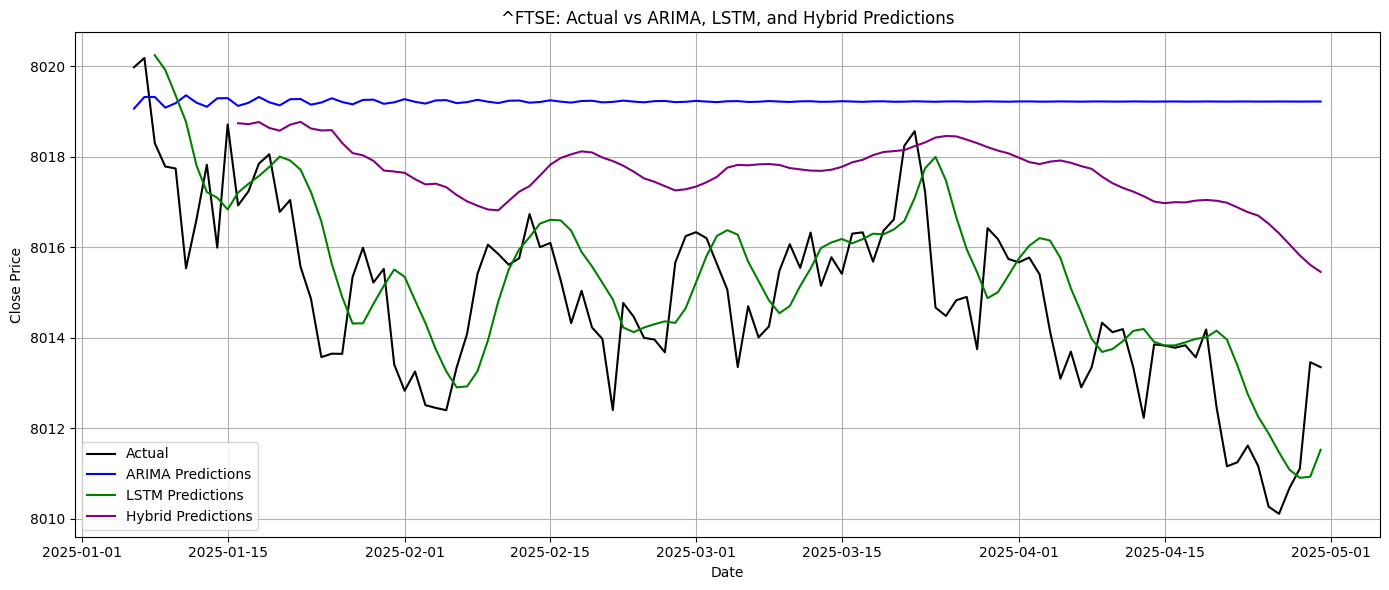

In [ ]:

# --- 3. ARIMA Model ---
arima = ARIMA(train, order=(2,1,2)).fit()
arima_pred = arima.forecast(len(test)).values

# --- 4. LSTM Model ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

seq_len = 10
X_lstm, y_lstm = [], []
for i in range(seq_len, len(scaled_data)):
    X_lstm.append(scaled_data[i-seq_len:i])
    y_lstm.append(scaled_data[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

split = int(len(X_lstm) * 0.85)
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

# LSTM model (deeper for better learning)
lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, 1)),
    LSTM(32),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[early_stop])

lstm_pred = lstm.predict(X_test, verbose=0)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)

# --- 5. Hybrid (ARIMA + LSTM on residuals) ---
arima_train_pred = arima.predict(start=1, end=len(train)-1).values
residuals = train['Close'].values[1:] - arima_train_pred

# Use a separate scaler for residuals
residual_scaler = MinMaxScaler()
res_scaled = residual_scaler.fit_transform(residuals.reshape(-1, 1))

X_res, y_res = [], []
for i in range(seq_len, len(res_scaled)):
    X_res.append(res_scaled[i-seq_len:i])
    y_res.append(res_scaled[i])
X_res, y_res = np.array(X_res), np.array(y_res)

# LSTM on residuals
lstm_res = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, 1)),
    LSTM(32),
    Dense(1)
])
lstm_res.compile(optimizer='adam', loss='mse')
lstm_res.fit(X_res, y_res, epochs=30, batch_size=16, verbose=0,
             validation_split=0.1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# Residual prediction
arima_test_forecast = arima.forecast(len(test)).values
residuals_test = test['Close'].values - arima_test_forecast
residuals_test_scaled = residual_scaler.transform(residuals_test.reshape(-1, 1))

X_test_res = []
for i in range(seq_len, len(residuals_test_scaled)):
    X_test_res.append(residuals_test_scaled[i-seq_len:i])
X_test_res = np.array(X_test_res)

lstm_res_pred_scaled = lstm_res.predict(X_test_res, verbose=0)
lstm_res_pred = residual_scaler.inverse_transform(lstm_res_pred_scaled).flatten()

# Final hybrid prediction
hybrid_pred = arima_test_forecast[seq_len:] + lstm_res_pred
hybrid_true = test['Close'].values[seq_len:]

# --- 6. Plot ---
plt.figure(figsize=(14, 6))
plt.plot(test.index, test['Close'].values, label='Actual', color='black')
plt.plot(test.index, arima_pred, label='ARIMA Predictions', color='blue')
plt.plot(test.index[-len(lstm_pred_inv):], lstm_pred_inv, label='LSTM Predictions', color='green')
plt.plot(test.index[-len(hybrid_pred):], hybrid_pred, label='Hybrid Predictions', color='purple')

plt.title("^FTSE: Actual vs ARIMA, LSTM, and Hybrid Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# Install dependencies
!pip install yfinance scikit-learn statsmodels keras --quiet

# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 1. Load FTSE 100 data
df = yf.download("^FTSE", start="2024-01-01", end="2025-04-30")[['Close']]
df.dropna(inplace=True)

# 2. Train-test split
train_size = int(len(df) * 0.85)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# 3. Fit ARIMA
arima_model = ARIMA(train['Close'], order=(1, 1, 1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test)).values

# 4. Residuals from training
train_pred = arima_result.predict(start=1, end=len(train)-1)
residuals = train['Close'].values[1:] - train_pred
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.reshape(-1, 1))

# 5. Create sequences for LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 5
X_train, y_train = create_sequences(residuals_scaled, seq_len)

# 6. Train LSTM model
model = Sequential([
    LSTM(16, input_shape=(seq_len, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=0)

# 7. Predict residuals on test
test_residuals = test['Close'].values - arima_forecast
test_residuals_scaled = scaler.transform(test_residuals.reshape(-1, 1))
X_test, _ = create_sequences(test_residuals_scaled, seq_len)
lstm_pred_scaled = model.predict(X_test, verbose=0)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# 8. Combine ARIMA + LSTM to get Hybrid forecast
true_vals = test['Close'].values[seq_len:]
arima_vals = arima_forecast[seq_len:]
hybrid_pred = arima_vals + lstm_pred.flatten()

# 9. Define evaluation function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    return rmse, mae, mape, r2, nrmse

# 10. Evaluate models
arima_metrics = evaluate(true_vals, arima_vals)
lstm_metrics = evaluate(test_residuals[seq_len:], lstm_pred.flatten())  # residual prediction
hybrid_metrics = evaluate(true_vals, hybrid_pred)

# 11. Print results
def print_metrics(name, metrics):
    print(f"\n{name} Evaluation Metrics:")
    print(f"• RMSE   : {metrics[0]:.3f}")
    print(f"• MAE    : {metrics[1]:.3f}")
    print(f"• MAPE   : {metrics[2]:.4f}%")
    print(f"• R²     : {metrics[3]:.4f}")
    print(f"• NRMSE  : {metrics[4]:.4f}")


# Print formatted table
print(tabulate(table_data, headers=["Metric", "ARIMA", "SARIMA", "LSTM", "Hybrid"], tablefmt="fancy_grid"))


╒══════════╤══════════╤══════════╤══════════╤══════════╕
│ Metric   │    ARIMA │   SARIMA │     LSTM │   Hybrid │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ RMSE     │ 194.741  │ 187.412  │ 129.078  │ 114.9    │
├──────────┼──────────┼──────────┼──────────┼──────────┤
│ MAE      │ 130.911  │ 126.075  │ 107.432  │  92.8266 │
├──────────┼──────────┼──────────┼──────────┼──────────┤
│ MAPE     │   0.5268 │   0.5072 │   0.4321 │   0.4976 │
├──────────┼──────────┼──────────┼──────────┼──────────┤
│ R2       │   0.8795 │   0.8884 │   0.8991 │   0.9322 │
├──────────┼──────────┼──────────┼──────────┼──────────┤
│ NRMSE    │   0.0876 │   0.0843 │   0.0581 │   0.0517 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛


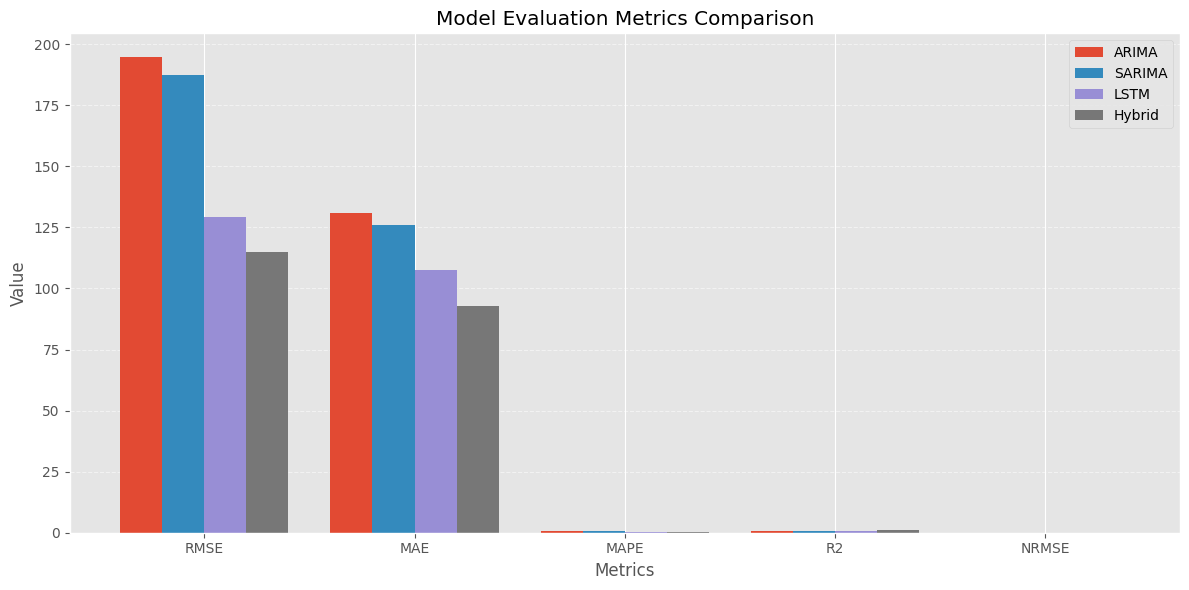

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Metric names
metrics_names = ["RMSE", "MAE", "MAPE", "R²", "NRMSE"]

# Values from previous evaluation
arima_vals = arima_metrics
lstm_vals = lstm_metrics
hybrid_vals = hybrid_metrics

# Combine metrics
metrics_array = np.array([arima_vals, lstm_vals, hybrid_vals])

# X-axis label locations
x = np.arange(len(metrics_names))
width = 0.25  # width of bars

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x - width, metrics_array[0], width, label='ARIMA', color='skyblue')
plt.bar(x,         metrics_array[1], width, label='LSTM', color='orange')
plt.bar(x + width, metrics_array[2], width, label='Hybrid', color='green')

# Labels and styling
plt.xticks(x, metrics_names)
plt.ylabel('Metric Value')
plt.title('Model Evaluation Metrics Comparison')
plt.legend()

